In [47]:
import tensorflow as tf
import parameters as par
import python_speech_features as psf
from os import listdir
from os.path import isdir, join
import librosa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras import Sequential, layers, regularizers, optimizers

In [48]:
# Settings
DATASET_PATH = 'C:\\Users\\elioe\\Documents\\wake-word-detection-model\\dataset'
FEATURE_SETS_PATH = 'C:\\Users\\elioe\\Documents\\wake-word-detection-model\\out'
FEATURE_SETS_FILENAME = 'features_16KWO_BACKGROUND.npz'
MODEL_FILENAME = 'model_test_wo.h5'

In [49]:
words = words = [name for name in listdir(DATASET_PATH) if isdir(join(DATASET_PATH, name))]
words.remove('_background_noise_')
print(words)

['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']


In [50]:
# Load feature sets
feature_sets = np.load(join(FEATURE_SETS_PATH, FEATURE_SETS_FILENAME))
print(feature_sets.files)

['features', 'targets']


In [51]:
def prepare_data(feature_sets, test_size, validation_size):
    # Assign feature sets
    x = feature_sets['features']
    y = feature_sets['targets']

    # Split to train, validation and test
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size)
    x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=validation_size)

    x_train = x_train[..., np.newaxis]
    x_test = x_test[..., np.newaxis]
    x_validation = x_validation[..., np.newaxis]

    return x_train, y_train, x_test, y_test, x_validation, y_validation

def cnn(sample_shape, learning_rate):
    model = Sequential(
        layers = [
            # Convolutional layer 1
            layers.Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=sample_shape),
            layers.BatchNormalization(),
            layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'),

            #Convolutional layer 2
            layers.Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
            layers.BatchNormalization(),
            layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'),

            #Convolutional layer 3
            layers.Conv2D(32, kernel_size=(2, 2), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
            layers.BatchNormalization(),
            layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),

            #Classification layer
            layers.Flatten(),
            layers.Dense(64, activation='relu'),
            layers.Dropout(0.2),

            # Softmax classifier
            layers.Dense(par.NUM_CLASSES, activation='softmax')
        ], name = 'CNN'
    )

    optimizer = optimizers.Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

    model.summary()

    return model

def train(model, epochs, batch_size, patience, x_train, y_train, x_validation, y_validation):
    earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0.001, patience=patience, mode='auto', restore_best_weights=True)

    # train model
    history = model.fit(
        x_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_validation, y_validation),
        callbacks=[earlystop_callback]
    )
    return history

def visualize_results(history):
    plt.figure(figsize=(16, 6))
    plt.suptitle('CNN results')

    plt.subplot(1, 2, 1, label='Loss plot')
    plt.plot(np.arange(1, len(history.history['loss'])+1), history.history['loss'])
    plt.plot(np.arange(1, len(history.history['val_loss'])+1), history.history['val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training set', 'Validation set'], loc='upper left')

    plt.subplot(1, 2, 2, label='Accuracy plot')
    plt.plot(np.arange(1, len(history.history['accuracy'])+1), history.history['accuracy'])
    plt.plot(np.arange(1, len(history.history['val_accuracy'])+1), history.history['val_accuracy'])
    plt.ylim([0, 1])
    plt.ylabel('Accuracy [%]')
    plt.xlabel('Epoch')
    plt.legend(['Training set', 'Validation set'], loc='upper left')

In [52]:
# Prepare data
x_train, y_train, x_test, y_test, x_validation, y_validation = prepare_data(feature_sets, 0.1, 0.1)

sample_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])
cnn = cnn(sample_shape, 0.001)

history = train(cnn, 12, 35, 5, x_train, y_train, x_validation, y_validation)

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 30, 11, 64)        640       
                                                                 
 batch_normalization_12 (Bat  (None, 30, 11, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 15, 6, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 13, 4, 32)         18464     
                                                                 
 batch_normalization_13 (Bat  (None, 13, 4, 32)        128       
 chNormalization)                                                
                                                               

In [53]:
test_loss, test_acc = cnn.evaluate(x_test, y_test)
print(f"Test loss: {test_loss}, test accuracy: {test_acc}")

#print(y_test)
y_predicted = tf.argmax(cnn.predict(x_test), axis=1)
#print(y_predicted)

299/299 [==============================] - 2s 7ms/step - loss: 0.5309 - accuracy: 0.8722
Test loss: 0.5309237837791443, test accuracy: 0.8722222447395325
299/299 [==============================] - 1s 4ms/step


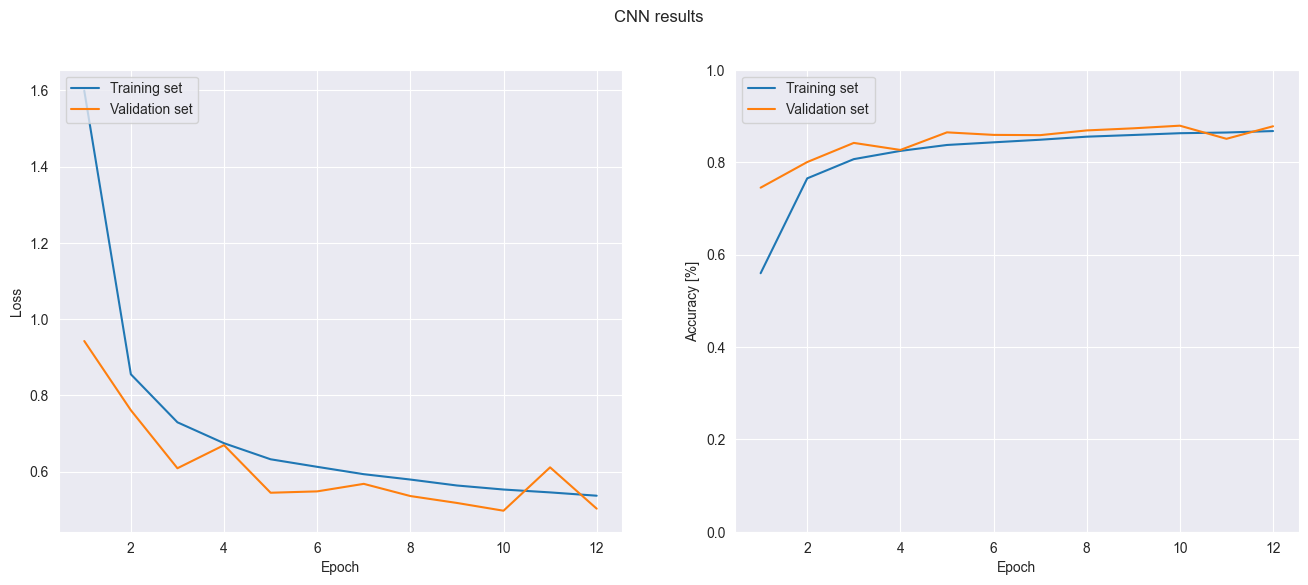

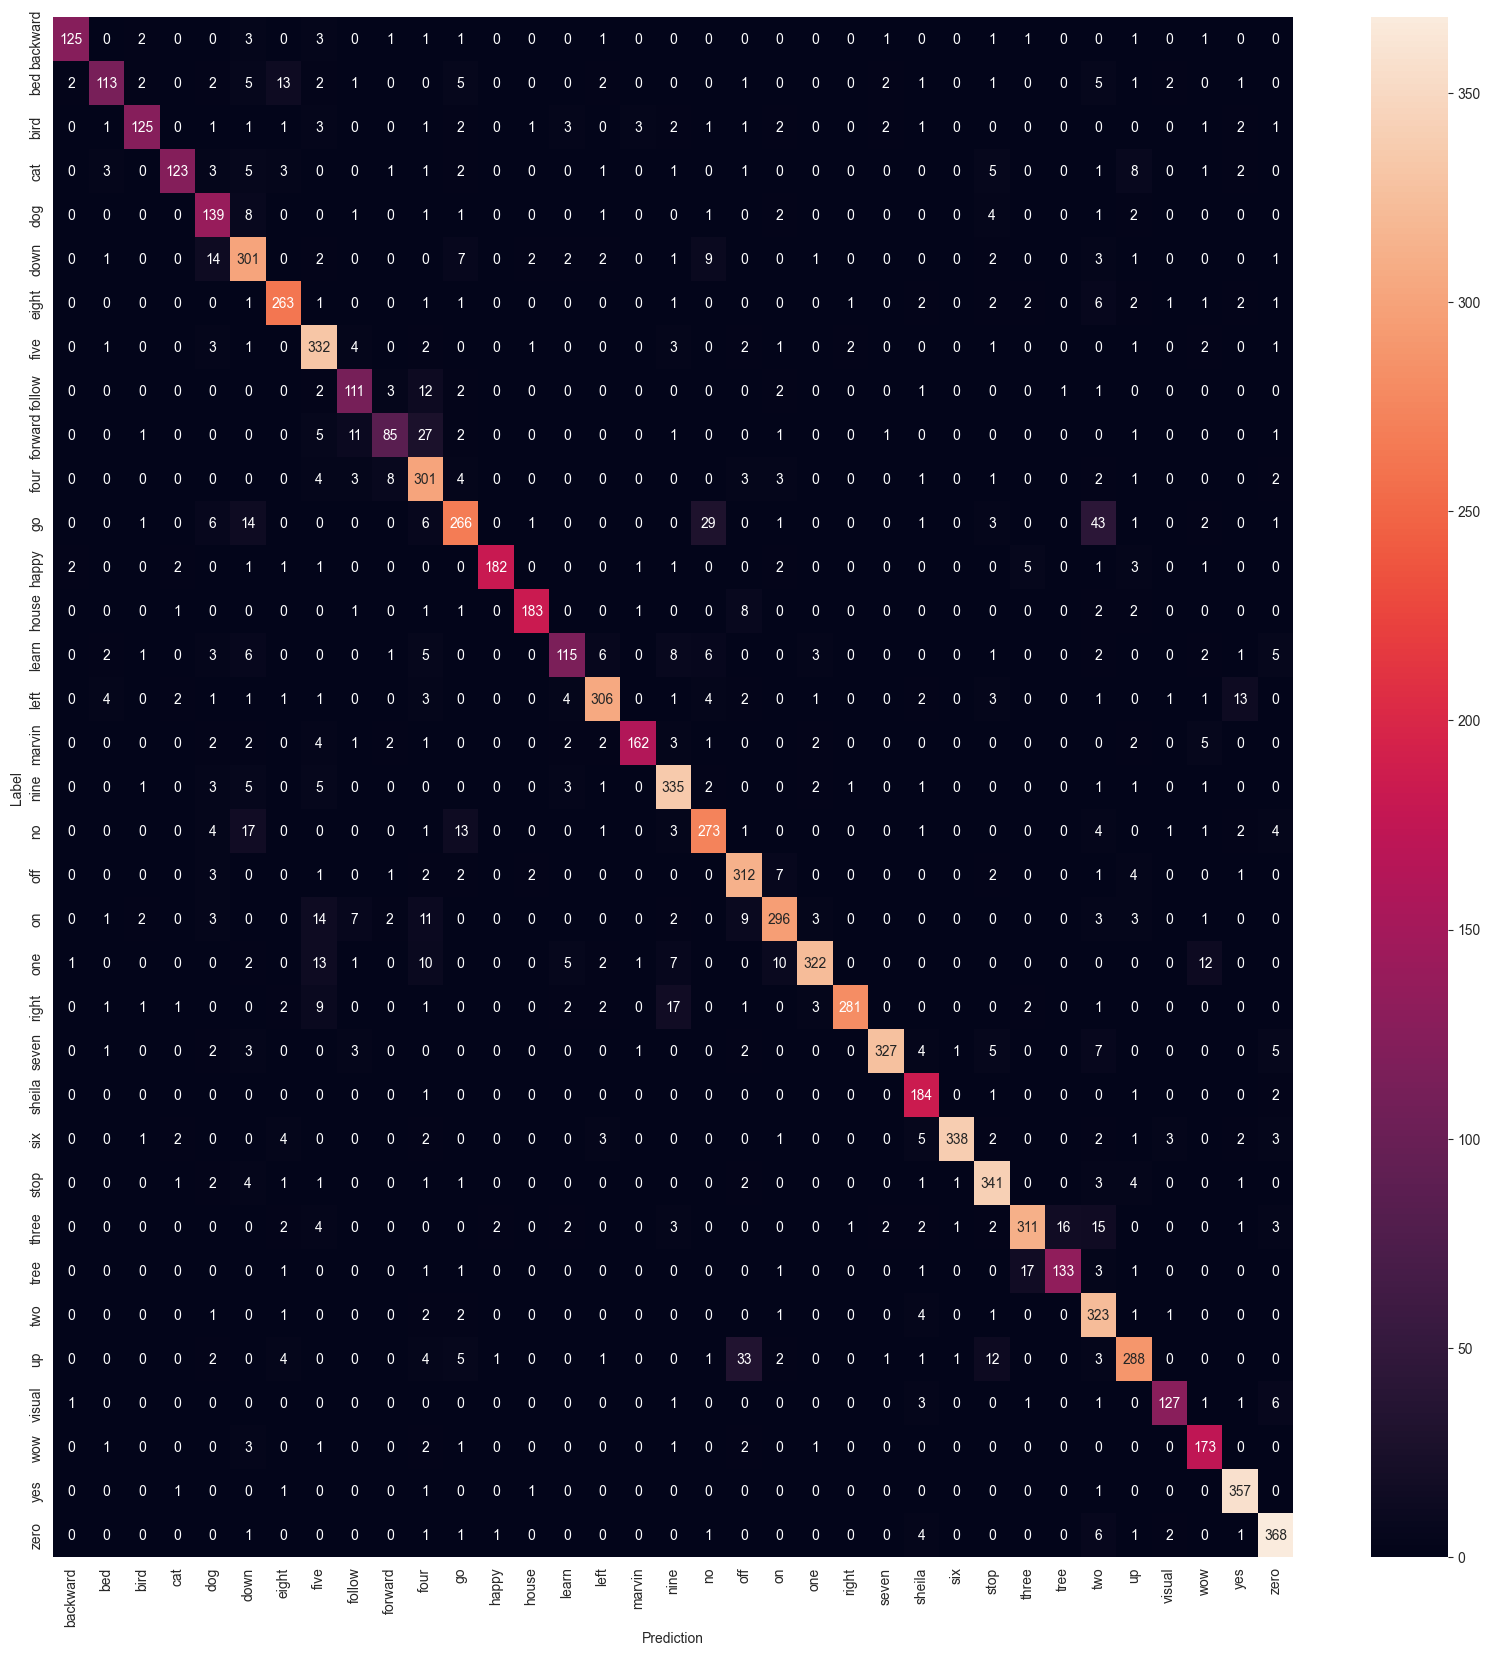

In [54]:
# Visualize results
#visualize_results(history)

plt.figure(figsize=(16, 6))
plt.suptitle('CNN results')

plt.subplot(1, 2, 1, label='Loss plot')
plt.plot(np.arange(1, len(history.history['loss'])+1), history.history['loss'])
plt.plot(np.arange(1, len(history.history['val_loss'])+1), history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper left')

plt.subplot(1, 2, 2, label='Accuracy plot')
plt.plot(np.arange(1, len(history.history['accuracy'])+1), history.history['accuracy'])
plt.plot(np.arange(1, len(history.history['val_accuracy'])+1), history.history['val_accuracy'])
plt.ylim([0, 1])
plt.ylabel('Accuracy [%]')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper left')

confusion_mtx = tf.math.confusion_matrix(y_test, y_predicted)
plt.figure(figsize=(20, 20))
sns.heatmap(confusion_mtx,
            xticklabels=par.WORDS,
            yticklabels=par.WORDS,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [55]:
# Prediction test
#print(sample_shape)
TEST_PATH = 'D:\\Downloads\\marvin_1.wav'
SAMPLES_TO_CONSIDER = par.SAMPLE_RATE

signal, sample_rate = librosa.load(TEST_PATH, sr=par.SAMPLE_RATE)

# Drop audio with sample rate lower than expected
if len(signal) >= SAMPLES_TO_CONSIDER:

    # Cut signal to the same length
    signal = signal[:SAMPLES_TO_CONSIDER]

else:
    # Pad signal with zeros
    signal = np.pad(signal, (0, par.SAMPLE_RATE - len(signal)), 'constant')

MFCCs = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=13, n_fft=400, hop_length=512)
# MFCCs = psf.base.mfcc(signal,
#                                 samplerate=sample_rate,
#                                 #winlen=par.N_FFT / sample_rate,
#                                 #winstep=par.HOP_SIZE / sample_rate,
#                                 numcep=par.NUM_MFCC,
#                                 nfilt=26,
#                                 nfft=par.N_FFT,
#                                 preemph=0.0,
#                                 ceplifter=0,
#                                 appendEnergy=False,
#                                 winfunc=np.hanning
#                               )
print(MFCCs.shape)
MFCCs = MFCCs.T
print(MFCCs[0])
predict_input = MFCCs[np.newaxis, ..., np.newaxis]
print(predict_input.shape)
predictions = cnn.predict(predict_input)
print(predictions)
print(words[np.argmax(predictions)])

(13, 32)
[-7.6578955e+02  4.6589694e+00 -4.9960869e+01 -4.7619877e+00
 -7.5129998e-01  1.1292288e+01 -1.9734740e-02 -2.5456331e+01
  4.2002053e+00  1.2572364e+01 -4.7321715e+00  1.0357776e+00
  1.1517014e+01]
(1, 32, 13, 1)
1/1 [==============================] - 0s 29ms/step
[[3.4057910e-03 2.4512599e-04 1.4690271e-01 1.0961699e-04 2.9600353e-03
  7.8628561e-04 7.2359288e-04 8.2757568e-04 2.9074170e-03 1.5836772e-02
  3.7757733e-03 7.9874252e-04 1.4488097e-02 1.2902034e-03 8.4954016e-03
  2.7283822e-04 7.6251447e-01 7.7461242e-03 3.7512110e-04 1.3352669e-03
  4.1449615e-03 7.2455552e-04 2.0717587e-03 3.1899482e-03 3.1968780e-04
  7.6765835e-05 2.2442589e-05 5.0536925e-03 2.3111135e-03 6.6831027e-04
  1.6131897e-03 1.4594656e-04 3.0853822e-05 2.1407336e-03 1.6891030e-03]]
marvin


In [56]:
# Save model
cnn.save(MODEL_FILENAME)